In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)
    
    dataset.drop('Precipitacao', axis=1, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                              
2015-01-01        35.0        23.7        5.9              10.2   
2015-01-02        35.8        23.0       10.6              10.2   
2015-01-03        31.9        22.3        4.3               6.2   
2015-01-04        27.3        20.7        1.9               3.5   
2015-01-05        32.4        20.7        8.3               1.5   
...                ...         ...        ...               ...   
2018-04-26        31.0        20.8        8.9               0.5   
2018-04-27        31.7        22.9       10.5               0.5   
2018-04-28        31.3        21.5        9.5               0.5   
2018-04-29        28.9        22.7        2.5               0.5   
2018-04-30        28.9        21.9        2.5               0.5   

            Temp Comp Media  Umidade Relativa Media  Velocidade do Vento Media  
date                                           

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values
features = len(dataset.columns)

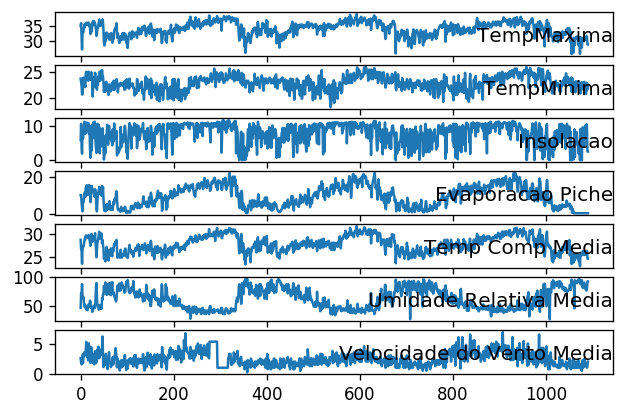

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,features)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,features)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,features)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,features)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
        
    return [y_hats, y_tests]

In [11]:
def metrics(y_hats, y_tests):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    percentual = 100
    n = len(y_hats)
    j = 1
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_max[i] - y_tests_max[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1
    
    print('\nMinimum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))
    
    j = 1
    percentual = 100
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_min[i] - y_tests_min[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1

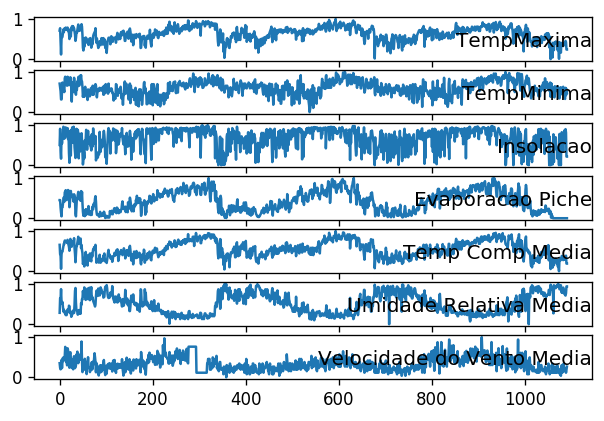

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3476 - mean_squared_error: 0.1729 - val_loss: 0.1921 - val_mean_squared_error: 0.0625
Epoch 2/1000
 - 0s - loss: 0.1533 - mean_squared_error: 0.0377 - val_loss: 0.1183 - val_mean_squared_error: 0.0234
Epoch 3/1000
 - 0s - loss: 0.1344 - mean_squared_error: 0.0287 - val_loss: 0.1932 - val_mean_squared_error: 0.0605
Epoch 4/1000
 - 0s - loss: 0.1244 - mean_squared_error: 0.0249 - val_loss: 0.1876 - val_mean_squared_error: 0.0551
Epoch 5/1000
 - 0s - loss: 0.1152 - mean_squared_error: 0.0221 - val_loss: 0.1570 - val_mean_squared_error: 0.0451
Epoch 6/1000
 - 0s - loss: 0.1123 - mean_squared_error: 0.0211 - val_loss: 0.1833 - val_mean_squared_error: 0.0578
Epoch 7/1000
 - 0s - loss: 0.1096 - mean_squared_error: 0.0200 - val_loss: 0.1747 - val_mean_squared_error: 0.0503
Epoch 8/1000
 - 0s - loss: 0.1092 - mean_squared_error: 0.0200 - val_loss: 0.1670 - val_mean_squared_error: 0.0506
Epoch 9/1000
 - 0s - loss: 0.1077 -

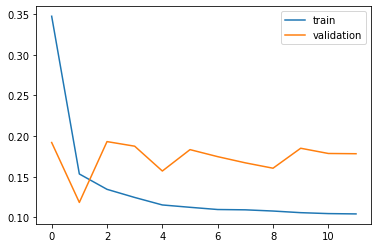


predict: [[31.30293329 22.7523617 ]]
real:      [[28.9 21.9]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2805 - mean_squared_error: 0.1160 - val_loss: 0.2468 - val_mean_squared_error: 0.0638
Epoch 2/1000
 - 0s - loss: 0.1587 - mean_squared_error: 0.0395 - val_loss: 0.1218 - val_mean_squared_error: 0.0190
Epoch 3/1000
 - 0s - loss: 0.1423 - mean_squared_error: 0.0320 - val_loss: 0.1482 - val_mean_squared_error: 0.0220
Epoch 4/1000
 - 0s - loss: 0.1377 - mean_squared_error: 0.0302 - val_loss: 0.1124 - val_mean_squared_error: 0.0127
Epoch 5/1000
 - 0s - loss: 0.1332 - mean_squared_error: 0.0286 - val_loss: 0.1216 - val_mean_squared_error: 0.0152
Epoch 6/1000
 - 0s - loss: 0.1286 - mean_squared_error: 0.0262 - val_loss: 0.1434 - val_mean_squared_error: 0.0208
Epoch 7/1000
 - 0s - loss: 0.1196 - mean_squared_error: 0.0228 - val_loss: 0.1302 - val_mean_squared_error: 0.0173
Epoch 8/1000
 - 0s - loss: 0.1124 - mean_squared_error: 0.0204 - val_loss: 0.1326 - va

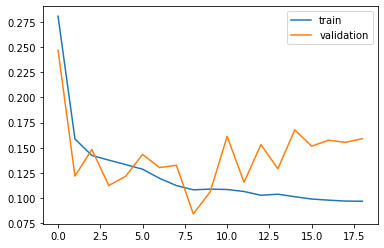


predict: [[31.97874444 22.26294377]]
real:      [[28.9 22.7]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3365 - mean_squared_error: 0.1647 - val_loss: 0.1481 - val_mean_squared_error: 0.0222
Epoch 2/1000
 - 0s - loss: 0.1628 - mean_squared_error: 0.0421 - val_loss: 0.0528 - val_mean_squared_error: 0.0046
Epoch 3/1000
 - 0s - loss: 0.1400 - mean_squared_error: 0.0318 - val_loss: 0.0519 - val_mean_squared_error: 0.0037
Epoch 4/1000
 - 0s - loss: 0.1346 - mean_squared_error: 0.0288 - val_loss: 0.0485 - val_mean_squared_error: 0.0043
Epoch 5/1000
 - 0s - loss: 0.1316 - mean_squared_error: 0.0279 - val_loss: 0.0409 - val_mean_squared_error: 0.0026
Epoch 6/1000
 - 0s - loss: 0.1271 - mean_squared_error: 0.0260 - val_loss: 0.0873 - val_mean_squared_error: 0.0116
Epoch 7/1000
 - 0s - loss: 0.1213 - mean_squared_error: 0.0236 - val_loss: 0.0779 - val_mean_squared_error: 0.0094
Epoch 8/1000
 - 0s - loss: 0.1136 - mean_squared_error: 0.0212 - val_loss: 0.1133 - va

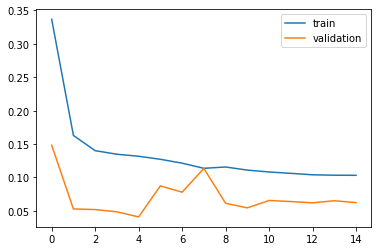


predict: [[32.29153116 22.89233   ]]
real:      [[31.3 21.5]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6367 - mean_squared_error: 0.4432 - val_loss: 0.3315 - val_mean_squared_error: 0.1345
Epoch 2/1000
 - 0s - loss: 0.5641 - mean_squared_error: 0.3914 - val_loss: 0.3970 - val_mean_squared_error: 0.2205
Epoch 3/1000
 - 0s - loss: 0.5075 - mean_squared_error: 0.3894 - val_loss: 0.3296 - val_mean_squared_error: 0.1475
Epoch 4/1000
 - 0s - loss: 0.4577 - mean_squared_error: 0.3218 - val_loss: 0.3287 - val_mean_squared_error: 0.1314
Epoch 5/1000
 - 0s - loss: 0.4269 - mean_squared_error: 0.2757 - val_loss: 0.3454 - val_mean_squared_error: 0.1298
Epoch 6/1000
 - 0s - loss: 0.3984 - mean_squared_error: 0.2453 - val_loss: 0.3268 - val_mean_squared_error: 0.1124
Epoch 7/1000
 - 0s - loss: 0.3731 - mean_squared_error: 0.2168 - val_loss: 0.3040 - val_mean_squared_error: 0.0954
Epoch 8/1000
 - 0s - loss: 0.3480 - mean_squared_error: 0.1915 - val_loss: 0.2520 - va

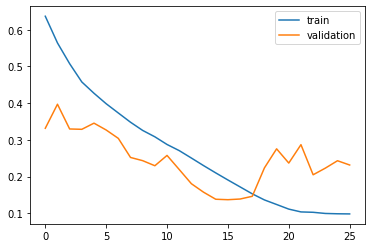


predict: [[31.0133792  23.17306795]]
real:      [[31.7 22.9]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3303 - mean_squared_error: 0.1638 - val_loss: 0.1200 - val_mean_squared_error: 0.0144
Epoch 2/1000
 - 0s - loss: 0.1738 - mean_squared_error: 0.0462 - val_loss: 0.1276 - val_mean_squared_error: 0.0177
Epoch 3/1000
 - 0s - loss: 0.1410 - mean_squared_error: 0.0318 - val_loss: 0.1741 - val_mean_squared_error: 0.0305
Epoch 4/1000
 - 0s - loss: 0.1331 - mean_squared_error: 0.0290 - val_loss: 0.2013 - val_mean_squared_error: 0.0405
Epoch 5/1000
 - 0s - loss: 0.1252 - mean_squared_error: 0.0261 - val_loss: 0.1691 - val_mean_squared_error: 0.0288
Epoch 6/1000
 - 0s - loss: 0.1191 - mean_squared_error: 0.0240 - val_loss: 0.1816 - val_mean_squared_error: 0.0336
Epoch 7/1000
 - 0s - loss: 0.1140 - mean_squared_error: 0.0219 - val_loss: 0.1647 - val_mean_squared_error: 0.0275
Epoch 8/1000
 - 0s - loss: 0.1118 - mean_squared_error: 0.0210 - val_loss: 0.2063 - va

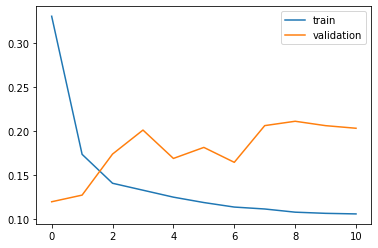


predict: [[32.57940226 20.17993672]]
real:      [[31.  20.8]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4061 - mean_squared_error: 0.2252 - val_loss: 0.2888 - val_mean_squared_error: 0.0887
Epoch 2/1000
 - 0s - loss: 0.1637 - mean_squared_error: 0.0432 - val_loss: 0.0799 - val_mean_squared_error: 0.0083
Epoch 3/1000
 - 0s - loss: 0.1435 - mean_squared_error: 0.0326 - val_loss: 0.1731 - val_mean_squared_error: 0.0303
Epoch 4/1000
 - 0s - loss: 0.1359 - mean_squared_error: 0.0292 - val_loss: 0.1657 - val_mean_squared_error: 0.0291
Epoch 5/1000
 - 0s - loss: 0.1338 - mean_squared_error: 0.0284 - val_loss: 0.1524 - val_mean_squared_error: 0.0246
Epoch 6/1000
 - 0s - loss: 0.1323 - mean_squared_error: 0.0280 - val_loss: 0.1540 - val_mean_squared_error: 0.0241
Epoch 7/1000
 - 0s - loss: 0.1288 - mean_squared_error: 0.0263 - val_loss: 0.1631 - val_mean_squared_error: 0.0268
Epoch 8/1000
 - 0s - loss: 0.1241 - mean_squared_error: 0.0245 - val_loss: 0.1841 - va

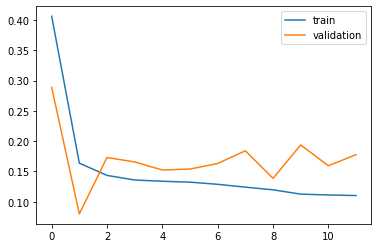


predict: [[31.70228665 22.00823561]]
real:      [[30.7 21. ]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2103 - mean_squared_error: 0.0707 - val_loss: 0.1026 - val_mean_squared_error: 0.0135
Epoch 2/1000
 - 0s - loss: 0.1485 - mean_squared_error: 0.0338 - val_loss: 0.1439 - val_mean_squared_error: 0.0268
Epoch 3/1000
 - 0s - loss: 0.1393 - mean_squared_error: 0.0307 - val_loss: 0.1353 - val_mean_squared_error: 0.0246
Epoch 4/1000
 - 0s - loss: 0.1316 - mean_squared_error: 0.0274 - val_loss: 0.1166 - val_mean_squared_error: 0.0203
Epoch 5/1000
 - 0s - loss: 0.1260 - mean_squared_error: 0.0253 - val_loss: 0.1273 - val_mean_squared_error: 0.0202
Epoch 6/1000
 - 0s - loss: 0.1178 - mean_squared_error: 0.0224 - val_loss: 0.1311 - val_mean_squared_error: 0.0220
Epoch 7/1000
 - 0s - loss: 0.1166 - mean_squared_error: 0.0219 - val_loss: 0.1186 - val_mean_squared_error: 0.0187
Epoch 8/1000
 - 0s - loss: 0.1139 - mean_squared_error: 0.0213 - val_loss: 0.1074 - va

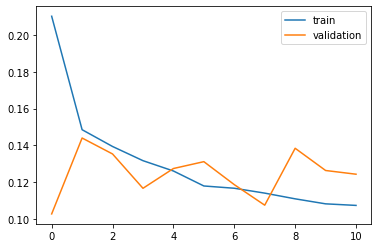


predict: [[32.05069487 21.81530083]]
real:      [[30.6 21.7]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4025 - mean_squared_error: 0.2197 - val_loss: 0.3225 - val_mean_squared_error: 0.1157
Epoch 2/1000
 - 0s - loss: 0.1620 - mean_squared_error: 0.0409 - val_loss: 0.1586 - val_mean_squared_error: 0.0369
Epoch 3/1000
 - 0s - loss: 0.1400 - mean_squared_error: 0.0309 - val_loss: 0.1408 - val_mean_squared_error: 0.0316
Epoch 4/1000
 - 0s - loss: 0.1340 - mean_squared_error: 0.0291 - val_loss: 0.1469 - val_mean_squared_error: 0.0307
Epoch 5/1000
 - 0s - loss: 0.1273 - mean_squared_error: 0.0261 - val_loss: 0.1422 - val_mean_squared_error: 0.0281
Epoch 6/1000
 - 0s - loss: 0.1207 - mean_squared_error: 0.0236 - val_loss: 0.1206 - val_mean_squared_error: 0.0232
Epoch 7/1000
 - 0s - loss: 0.1160 - mean_squared_error: 0.0218 - val_loss: 0.1358 - val_mean_squared_error: 0.0348
Epoch 8/1000
 - 0s - loss: 0.1113 - mean_squared_error: 0.0204 - val_loss: 0.1256 - va

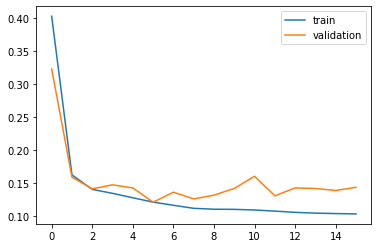


predict: [[31.57766818 22.53318717]]
real:      [[30.3 22.3]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3889 - mean_squared_error: 0.2118 - val_loss: 0.1726 - val_mean_squared_error: 0.0311
Epoch 2/1000
 - 0s - loss: 0.1691 - mean_squared_error: 0.0465 - val_loss: 0.0785 - val_mean_squared_error: 0.0071
Epoch 3/1000
 - 0s - loss: 0.1521 - mean_squared_error: 0.0373 - val_loss: 0.0987 - val_mean_squared_error: 0.0097
Epoch 4/1000
 - 0s - loss: 0.1422 - mean_squared_error: 0.0324 - val_loss: 0.0721 - val_mean_squared_error: 0.0075
Epoch 5/1000
 - 0s - loss: 0.1366 - mean_squared_error: 0.0300 - val_loss: 0.0955 - val_mean_squared_error: 0.0158
Epoch 6/1000
 - 0s - loss: 0.1307 - mean_squared_error: 0.0272 - val_loss: 0.1123 - val_mean_squared_error: 0.0187
Epoch 7/1000
 - 0s - loss: 0.1264 - mean_squared_error: 0.0260 - val_loss: 0.0829 - val_mean_squared_error: 0.0135
Epoch 8/1000
 - 0s - loss: 0.1173 - mean_squared_error: 0.0226 - val_loss: 0.0740 - va

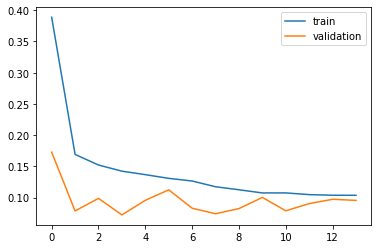


predict: [[32.46507548 22.38522034]]
real:      [[30.  23.1]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3380 - mean_squared_error: 0.1710 - val_loss: 0.1437 - val_mean_squared_error: 0.0297
Epoch 2/1000
 - 0s - loss: 0.1549 - mean_squared_error: 0.0372 - val_loss: 0.0833 - val_mean_squared_error: 0.0091
Epoch 3/1000
 - 0s - loss: 0.1368 - mean_squared_error: 0.0305 - val_loss: 0.1088 - val_mean_squared_error: 0.0178
Epoch 4/1000
 - 0s - loss: 0.1329 - mean_squared_error: 0.0285 - val_loss: 0.0813 - val_mean_squared_error: 0.0077
Epoch 5/1000
 - 0s - loss: 0.1257 - mean_squared_error: 0.0254 - val_loss: 0.0939 - val_mean_squared_error: 0.0107
Epoch 6/1000
 - 0s - loss: 0.1197 - mean_squared_error: 0.0230 - val_loss: 0.1029 - val_mean_squared_error: 0.0116
Epoch 7/1000
 - 0s - loss: 0.1149 - mean_squared_error: 0.0215 - val_loss: 0.0894 - val_mean_squared_error: 0.0095
Epoch 8/1000
 - 0s - loss: 0.1099 - mean_squared_error: 0.0200 - val_loss: 0.0892 - va

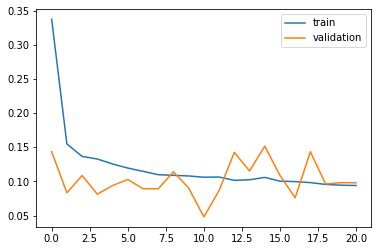


predict: [[30.50881569 21.96529437]]
real:      [[31.1 22.8]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4329 - mean_squared_error: 0.2509 - val_loss: 0.3423 - val_mean_squared_error: 0.1212
Epoch 2/1000
 - 0s - loss: 0.2248 - mean_squared_error: 0.0726 - val_loss: 0.2005 - val_mean_squared_error: 0.0405
Epoch 3/1000
 - 0s - loss: 0.1545 - mean_squared_error: 0.0372 - val_loss: 0.1072 - val_mean_squared_error: 0.0159
Epoch 4/1000
 - 0s - loss: 0.1356 - mean_squared_error: 0.0297 - val_loss: 0.0876 - val_mean_squared_error: 0.0152
Epoch 5/1000
 - 0s - loss: 0.1324 - mean_squared_error: 0.0287 - val_loss: 0.0757 - val_mean_squared_error: 0.0100
Epoch 6/1000
 - 0s - loss: 0.1308 - mean_squared_error: 0.0280 - val_loss: 0.0991 - val_mean_squared_error: 0.0178
Epoch 7/1000
 - 0s - loss: 0.1274 - mean_squared_error: 0.0265 - val_loss: 0.0818 - val_mean_squared_error: 0.0128
Epoch 8/1000
 - 0s - loss: 0.1207 - mean_squared_error: 0.0245 - val_loss: 0.0800 - va

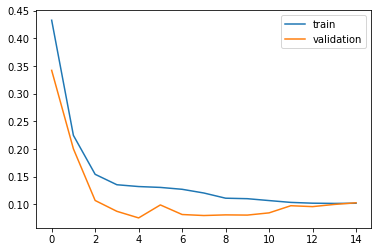


predict: [[31.96813543 22.28024366]]
real:      [[31.1 22.3]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5517 - mean_squared_error: 0.3515 - val_loss: 0.2123 - val_mean_squared_error: 0.0764
Epoch 2/1000
 - 0s - loss: 0.2888 - mean_squared_error: 0.1242 - val_loss: 0.1417 - val_mean_squared_error: 0.0385
Epoch 3/1000
 - 0s - loss: 0.1490 - mean_squared_error: 0.0348 - val_loss: 0.2099 - val_mean_squared_error: 0.0477
Epoch 4/1000
 - 0s - loss: 0.1414 - mean_squared_error: 0.0308 - val_loss: 0.2100 - val_mean_squared_error: 0.0457
Epoch 5/1000
 - 0s - loss: 0.1382 - mean_squared_error: 0.0301 - val_loss: 0.1848 - val_mean_squared_error: 0.0343
Epoch 6/1000
 - 0s - loss: 0.1357 - mean_squared_error: 0.0287 - val_loss: 0.1658 - val_mean_squared_error: 0.0275
Epoch 7/1000
 - 0s - loss: 0.1350 - mean_squared_error: 0.0285 - val_loss: 0.1934 - val_mean_squared_error: 0.0374
Epoch 8/1000
 - 0s - loss: 0.1323 - mean_squared_error: 0.0276 - val_loss: 0.1764 - va

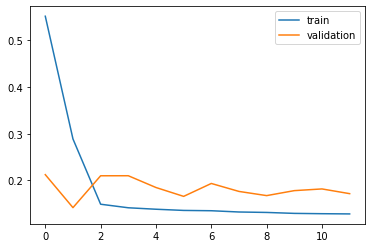


predict: [[33.89079611 21.48315834]]
real:      [[31.  22.8]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4012 - mean_squared_error: 0.2148 - val_loss: 0.3521 - val_mean_squared_error: 0.1268
Epoch 2/1000
 - 0s - loss: 0.1639 - mean_squared_error: 0.0457 - val_loss: 0.2290 - val_mean_squared_error: 0.0744
Epoch 3/1000
 - 0s - loss: 0.1460 - mean_squared_error: 0.0329 - val_loss: 0.2342 - val_mean_squared_error: 0.0810
Epoch 4/1000
 - 0s - loss: 0.1358 - mean_squared_error: 0.0304 - val_loss: 0.2122 - val_mean_squared_error: 0.0713
Epoch 5/1000
 - 0s - loss: 0.1313 - mean_squared_error: 0.0277 - val_loss: 0.2083 - val_mean_squared_error: 0.0717
Epoch 6/1000
 - 0s - loss: 0.1263 - mean_squared_error: 0.0258 - val_loss: 0.2104 - val_mean_squared_error: 0.0837
Epoch 7/1000
 - 0s - loss: 0.1214 - mean_squared_error: 0.0243 - val_loss: 0.1800 - val_mean_squared_error: 0.0470
Epoch 8/1000
 - 0s - loss: 0.1202 - mean_squared_error: 0.0230 - val_loss: 0.2374 - va

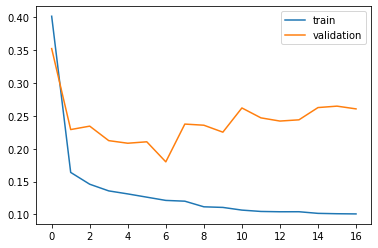


predict: [[30.49870532 22.7352421 ]]
real:      [[30.7 21.7]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5195 - mean_squared_error: 0.3242 - val_loss: 0.0969 - val_mean_squared_error: 0.0121
Epoch 2/1000
 - 0s - loss: 0.2195 - mean_squared_error: 0.0788 - val_loss: 0.2625 - val_mean_squared_error: 0.1266
Epoch 3/1000
 - 0s - loss: 0.1488 - mean_squared_error: 0.0354 - val_loss: 0.1570 - val_mean_squared_error: 0.0349
Epoch 4/1000
 - 0s - loss: 0.1396 - mean_squared_error: 0.0306 - val_loss: 0.1733 - val_mean_squared_error: 0.0524
Epoch 5/1000
 - 0s - loss: 0.1342 - mean_squared_error: 0.0286 - val_loss: 0.1745 - val_mean_squared_error: 0.0427
Epoch 6/1000
 - 0s - loss: 0.1320 - mean_squared_error: 0.0275 - val_loss: 0.1535 - val_mean_squared_error: 0.0395
Epoch 7/1000
 - 0s - loss: 0.1277 - mean_squared_error: 0.0260 - val_loss: 0.1491 - val_mean_squared_error: 0.0412
Epoch 8/1000
 - 0s - loss: 0.1251 - mean_squared_error: 0.0253 - val_loss: 0.1414 - va

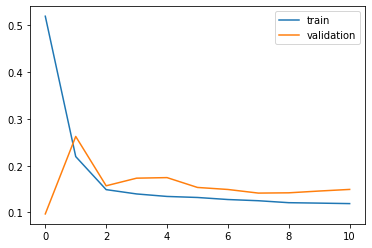


predict: [[27.53521033 22.15998292]]
real:      [[27.9 23. ]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3212 - mean_squared_error: 0.1482 - val_loss: 0.2242 - val_mean_squared_error: 0.0547
Epoch 2/1000
 - 0s - loss: 0.1549 - mean_squared_error: 0.0393 - val_loss: 0.1068 - val_mean_squared_error: 0.0126
Epoch 3/1000
 - 0s - loss: 0.1406 - mean_squared_error: 0.0308 - val_loss: 0.1667 - val_mean_squared_error: 0.0279
Epoch 4/1000
 - 0s - loss: 0.1363 - mean_squared_error: 0.0297 - val_loss: 0.1533 - val_mean_squared_error: 0.0254
Epoch 5/1000
 - 0s - loss: 0.1323 - mean_squared_error: 0.0277 - val_loss: 0.1684 - val_mean_squared_error: 0.0284
Epoch 6/1000
 - 0s - loss: 0.1280 - mean_squared_error: 0.0261 - val_loss: 0.1738 - val_mean_squared_error: 0.0311
Epoch 7/1000
 - 0s - loss: 0.1226 - mean_squared_error: 0.0243 - val_loss: 0.1775 - val_mean_squared_error: 0.0316
Epoch 8/1000
 - 0s - loss: 0.1194 - mean_squared_error: 0.0232 - val_loss: 0.1985 - va

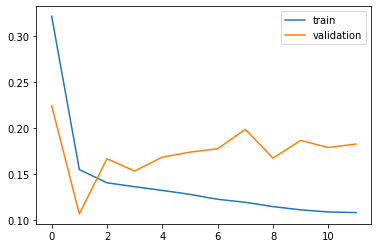


predict: [[31.47525566 22.06830256]]
real:      [[29.5 23. ]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3590 - mean_squared_error: 0.1835 - val_loss: 0.1782 - val_mean_squared_error: 0.0563
Epoch 2/1000
 - 0s - loss: 0.1700 - mean_squared_error: 0.0475 - val_loss: 0.1524 - val_mean_squared_error: 0.0238
Epoch 3/1000
 - 0s - loss: 0.1457 - mean_squared_error: 0.0339 - val_loss: 0.1974 - val_mean_squared_error: 0.0405
Epoch 4/1000
 - 0s - loss: 0.1395 - mean_squared_error: 0.0307 - val_loss: 0.2137 - val_mean_squared_error: 0.0471
Epoch 5/1000
 - 0s - loss: 0.1331 - mean_squared_error: 0.0282 - val_loss: 0.2106 - val_mean_squared_error: 0.0464
Epoch 6/1000
 - 0s - loss: 0.1259 - mean_squared_error: 0.0255 - val_loss: 0.1640 - val_mean_squared_error: 0.0298
Epoch 7/1000
 - 0s - loss: 0.1217 - mean_squared_error: 0.0235 - val_loss: 0.2307 - val_mean_squared_error: 0.0557
Epoch 8/1000
 - 0s - loss: 0.1151 - mean_squared_error: 0.0214 - val_loss: 0.3044 - va

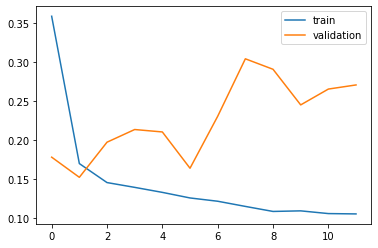


predict: [[32.377703   21.48282629]]
real:      [[30.7 21.8]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4712 - mean_squared_error: 0.2590 - val_loss: 0.2610 - val_mean_squared_error: 0.1116
Epoch 2/1000
 - 0s - loss: 0.1647 - mean_squared_error: 0.0443 - val_loss: 0.4326 - val_mean_squared_error: 0.2228
Epoch 3/1000
 - 0s - loss: 0.1387 - mean_squared_error: 0.0296 - val_loss: 0.4094 - val_mean_squared_error: 0.2016
Epoch 4/1000
 - 0s - loss: 0.1346 - mean_squared_error: 0.0286 - val_loss: 0.4139 - val_mean_squared_error: 0.2002
Epoch 5/1000
 - 0s - loss: 0.1326 - mean_squared_error: 0.0279 - val_loss: 0.3838 - val_mean_squared_error: 0.1720
Epoch 6/1000
 - 0s - loss: 0.1321 - mean_squared_error: 0.0275 - val_loss: 0.4215 - val_mean_squared_error: 0.2051
Epoch 7/1000
 - 0s - loss: 0.1295 - mean_squared_error: 0.0266 - val_loss: 0.4033 - val_mean_squared_error: 0.1950
Epoch 8/1000
 - 0s - loss: 0.1280 - mean_squared_error: 0.0263 - val_loss: 0.3939 - va

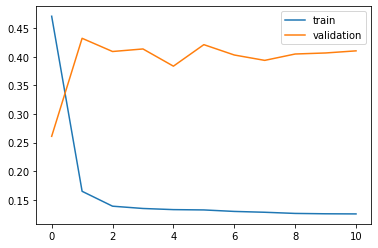


predict: [[30.76804756 20.8570835 ]]
real:      [[31.3 20.9]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3525 - mean_squared_error: 0.1713 - val_loss: 0.3651 - val_mean_squared_error: 0.1335
Epoch 2/1000
 - 0s - loss: 0.1584 - mean_squared_error: 0.0412 - val_loss: 0.2345 - val_mean_squared_error: 0.0632
Epoch 3/1000
 - 0s - loss: 0.1471 - mean_squared_error: 0.0342 - val_loss: 0.2225 - val_mean_squared_error: 0.0538
Epoch 4/1000
 - 0s - loss: 0.1377 - mean_squared_error: 0.0305 - val_loss: 0.2544 - val_mean_squared_error: 0.0670
Epoch 5/1000
 - 0s - loss: 0.1311 - mean_squared_error: 0.0277 - val_loss: 0.2757 - val_mean_squared_error: 0.0795
Epoch 6/1000
 - 0s - loss: 0.1223 - mean_squared_error: 0.0245 - val_loss: 0.1937 - val_mean_squared_error: 0.0411
Epoch 7/1000
 - 0s - loss: 0.1158 - mean_squared_error: 0.0222 - val_loss: 0.2236 - val_mean_squared_error: 0.0515
Epoch 8/1000
 - 0s - loss: 0.1105 - mean_squared_error: 0.0204 - val_loss: 0.1951 - va

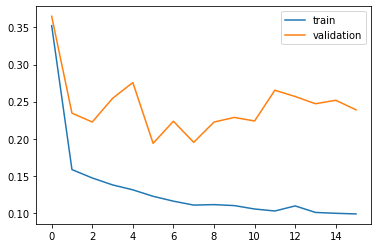


predict: [[32.17426147 22.59358141]]
real:      [[25.9 21.2]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3653 - mean_squared_error: 0.1836 - val_loss: 0.1477 - val_mean_squared_error: 0.0230
Epoch 2/1000
 - 0s - loss: 0.1653 - mean_squared_error: 0.0432 - val_loss: 0.0545 - val_mean_squared_error: 0.0031
Epoch 3/1000
 - 0s - loss: 0.1446 - mean_squared_error: 0.0326 - val_loss: 0.1156 - val_mean_squared_error: 0.0134
Epoch 4/1000
 - 0s - loss: 0.1366 - mean_squared_error: 0.0295 - val_loss: 0.0889 - val_mean_squared_error: 0.0081
Epoch 5/1000
 - 0s - loss: 0.1286 - mean_squared_error: 0.0256 - val_loss: 0.0938 - val_mean_squared_error: 0.0088
Epoch 6/1000
 - 0s - loss: 0.1201 - mean_squared_error: 0.0230 - val_loss: 0.1094 - val_mean_squared_error: 0.0128
Epoch 7/1000
 - 0s - loss: 0.1114 - mean_squared_error: 0.0204 - val_loss: 0.1079 - val_mean_squared_error: 0.0129
Epoch 8/1000
 - 0s - loss: 0.1120 - mean_squared_error: 0.0206 - val_loss: 0.1855 - va

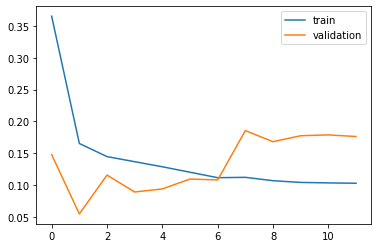


predict: [[30.79253082 22.07497133]]
real:      [[29.2 21.1]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3141 - mean_squared_error: 0.1534 - val_loss: 0.1889 - val_mean_squared_error: 0.0679
Epoch 2/1000
 - 0s - loss: 0.1618 - mean_squared_error: 0.0435 - val_loss: 0.2573 - val_mean_squared_error: 0.0737
Epoch 3/1000
 - 0s - loss: 0.1436 - mean_squared_error: 0.0327 - val_loss: 0.1875 - val_mean_squared_error: 0.0552
Epoch 4/1000
 - 0s - loss: 0.1341 - mean_squared_error: 0.0288 - val_loss: 0.1922 - val_mean_squared_error: 0.0543
Epoch 5/1000
 - 0s - loss: 0.1329 - mean_squared_error: 0.0286 - val_loss: 0.2202 - val_mean_squared_error: 0.0588
Epoch 6/1000
 - 0s - loss: 0.1237 - mean_squared_error: 0.0247 - val_loss: 0.1771 - val_mean_squared_error: 0.0415
Epoch 7/1000
 - 0s - loss: 0.1186 - mean_squared_error: 0.0223 - val_loss: 0.1996 - val_mean_squared_error: 0.0598
Epoch 8/1000
 - 0s - loss: 0.1122 - mean_squared_error: 0.0203 - val_loss: 0.1978 - va

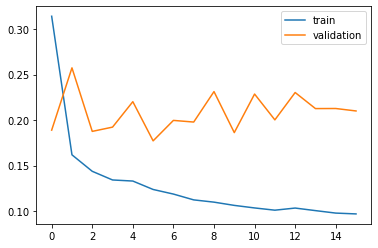


predict: [[31.82813289 22.40374966]]
real:      [[31.1 21.7]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4575 - mean_squared_error: 0.2683 - val_loss: 0.0585 - val_mean_squared_error: 0.0065
Epoch 2/1000
 - 0s - loss: 0.1517 - mean_squared_error: 0.0385 - val_loss: 0.0676 - val_mean_squared_error: 0.0072
Epoch 3/1000
 - 0s - loss: 0.1374 - mean_squared_error: 0.0301 - val_loss: 0.1276 - val_mean_squared_error: 0.0167
Epoch 4/1000
 - 0s - loss: 0.1368 - mean_squared_error: 0.0309 - val_loss: 0.0968 - val_mean_squared_error: 0.0116
Epoch 5/1000
 - 0s - loss: 0.1321 - mean_squared_error: 0.0282 - val_loss: 0.1011 - val_mean_squared_error: 0.0104
Epoch 6/1000
 - 0s - loss: 0.1305 - mean_squared_error: 0.0277 - val_loss: 0.1347 - val_mean_squared_error: 0.0203
Epoch 7/1000
 - 0s - loss: 0.1275 - mean_squared_error: 0.0267 - val_loss: 0.1068 - val_mean_squared_error: 0.0147
Epoch 8/1000
 - 0s - loss: 0.1263 - mean_squared_error: 0.0258 - val_loss: 0.1385 - va

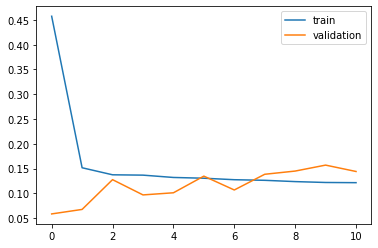


predict: [[32.0308875  22.06530894]]
real:      [[28.7 23.2]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5087 - mean_squared_error: 0.3308 - val_loss: 0.2639 - val_mean_squared_error: 0.0917
Epoch 2/1000
 - 0s - loss: 0.3463 - mean_squared_error: 0.1768 - val_loss: 0.0873 - val_mean_squared_error: 0.0132
Epoch 3/1000
 - 0s - loss: 0.1735 - mean_squared_error: 0.0470 - val_loss: 0.2122 - val_mean_squared_error: 0.0602
Epoch 4/1000
 - 0s - loss: 0.1397 - mean_squared_error: 0.0306 - val_loss: 0.0998 - val_mean_squared_error: 0.0105
Epoch 5/1000
 - 0s - loss: 0.1291 - mean_squared_error: 0.0259 - val_loss: 0.1433 - val_mean_squared_error: 0.0231
Epoch 6/1000
 - 0s - loss: 0.1188 - mean_squared_error: 0.0223 - val_loss: 0.1190 - val_mean_squared_error: 0.0174
Epoch 7/1000
 - 0s - loss: 0.1113 - mean_squared_error: 0.0202 - val_loss: 0.1042 - val_mean_squared_error: 0.0167
Epoch 8/1000
 - 0s - loss: 0.1058 - mean_squared_error: 0.0187 - val_loss: 0.0998 - va

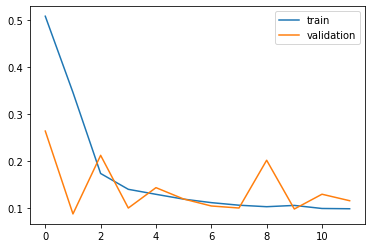


predict: [[28.67257229 22.35949247]]
real:      [[31.2 22.3]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4084 - mean_squared_error: 0.2327 - val_loss: 0.2083 - val_mean_squared_error: 0.0805
Epoch 2/1000
 - 0s - loss: 0.1673 - mean_squared_error: 0.0444 - val_loss: 0.0680 - val_mean_squared_error: 0.0050
Epoch 3/1000
 - 0s - loss: 0.1434 - mean_squared_error: 0.0326 - val_loss: 0.1000 - val_mean_squared_error: 0.0171
Epoch 4/1000
 - 0s - loss: 0.1364 - mean_squared_error: 0.0291 - val_loss: 0.0966 - val_mean_squared_error: 0.0123
Epoch 5/1000
 - 0s - loss: 0.1321 - mean_squared_error: 0.0273 - val_loss: 0.1095 - val_mean_squared_error: 0.0142
Epoch 6/1000
 - 0s - loss: 0.1271 - mean_squared_error: 0.0255 - val_loss: 0.0850 - val_mean_squared_error: 0.0105
Epoch 7/1000
 - 0s - loss: 0.1206 - mean_squared_error: 0.0235 - val_loss: 0.0781 - val_mean_squared_error: 0.0119
Epoch 8/1000
 - 0s - loss: 0.1138 - mean_squared_error: 0.0210 - val_loss: 0.0969 - va

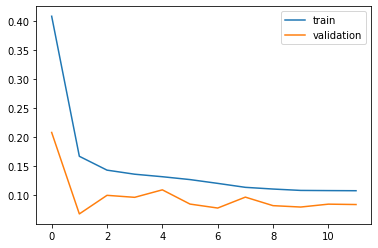


predict: [[31.74158369 22.20769103]]
real:      [[31.1 22.3]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3753 - mean_squared_error: 0.1971 - val_loss: 0.2316 - val_mean_squared_error: 0.0700
Epoch 2/1000
 - 0s - loss: 0.1624 - mean_squared_error: 0.0414 - val_loss: 0.0904 - val_mean_squared_error: 0.0082
Epoch 3/1000
 - 0s - loss: 0.1392 - mean_squared_error: 0.0315 - val_loss: 0.0835 - val_mean_squared_error: 0.0091
Epoch 4/1000
 - 0s - loss: 0.1321 - mean_squared_error: 0.0279 - val_loss: 0.0697 - val_mean_squared_error: 0.0080
Epoch 5/1000
 - 0s - loss: 0.1271 - mean_squared_error: 0.0259 - val_loss: 0.0604 - val_mean_squared_error: 0.0070
Epoch 6/1000
 - 0s - loss: 0.1225 - mean_squared_error: 0.0241 - val_loss: 0.0710 - val_mean_squared_error: 0.0069
Epoch 7/1000
 - 0s - loss: 0.1170 - mean_squared_error: 0.0223 - val_loss: 0.0706 - val_mean_squared_error: 0.0082
Epoch 8/1000
 - 0s - loss: 0.1150 - mean_squared_error: 0.0217 - val_loss: 0.0571 - va

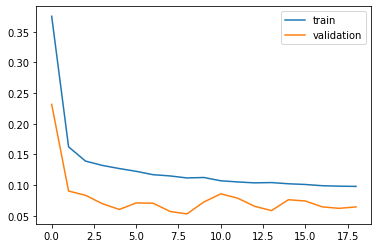


predict: [[31.39151998 22.51880503]]
real:      [[31.  22.8]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3635 - mean_squared_error: 0.1821 - val_loss: 0.1263 - val_mean_squared_error: 0.0263
Epoch 2/1000
 - 0s - loss: 0.2367 - mean_squared_error: 0.0854 - val_loss: 0.0461 - val_mean_squared_error: 0.0022
Epoch 3/1000
 - 0s - loss: 0.1852 - mean_squared_error: 0.0535 - val_loss: 0.0912 - val_mean_squared_error: 0.0100
Epoch 4/1000
 - 0s - loss: 0.1511 - mean_squared_error: 0.0370 - val_loss: 0.0987 - val_mean_squared_error: 0.0189
Epoch 5/1000
 - 0s - loss: 0.1382 - mean_squared_error: 0.0312 - val_loss: 0.1345 - val_mean_squared_error: 0.0257
Epoch 6/1000
 - 0s - loss: 0.1297 - mean_squared_error: 0.0280 - val_loss: 0.1368 - val_mean_squared_error: 0.0268
Epoch 7/1000
 - 0s - loss: 0.1220 - mean_squared_error: 0.0247 - val_loss: 0.1267 - val_mean_squared_error: 0.0217
Epoch 8/1000
 - 0s - loss: 0.1151 - mean_squared_error: 0.0224 - val_loss: 0.1201 - va

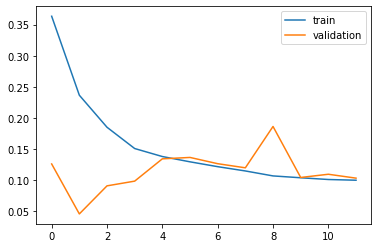


predict: [[30.06019517 22.09465216]]
real:      [[31.5 23. ]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3905 - mean_squared_error: 0.2349 - val_loss: 0.1395 - val_mean_squared_error: 0.0223
Epoch 2/1000
 - 0s - loss: 0.1610 - mean_squared_error: 0.0439 - val_loss: 0.1781 - val_mean_squared_error: 0.0320
Epoch 3/1000
 - 0s - loss: 0.1419 - mean_squared_error: 0.0326 - val_loss: 0.0986 - val_mean_squared_error: 0.0129
Epoch 4/1000
 - 0s - loss: 0.1322 - mean_squared_error: 0.0286 - val_loss: 0.1161 - val_mean_squared_error: 0.0160
Epoch 5/1000
 - 0s - loss: 0.1247 - mean_squared_error: 0.0256 - val_loss: 0.1104 - val_mean_squared_error: 0.0151
Epoch 6/1000
 - 0s - loss: 0.1184 - mean_squared_error: 0.0233 - val_loss: 0.0936 - val_mean_squared_error: 0.0130
Epoch 7/1000
 - 0s - loss: 0.1147 - mean_squared_error: 0.0216 - val_loss: 0.0950 - val_mean_squared_error: 0.0130
Epoch 8/1000
 - 0s - loss: 0.1106 - mean_squared_error: 0.0205 - val_loss: 0.1056 - va

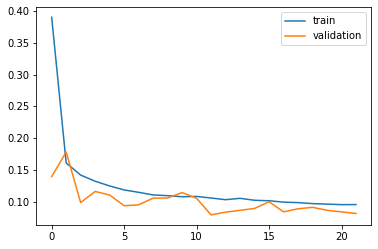


predict: [[30.61694707 22.16864872]]
real:      [[30.9 22.9]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4447 - mean_squared_error: 0.2435 - val_loss: 0.1385 - val_mean_squared_error: 0.0354
Epoch 2/1000
 - 0s - loss: 0.1692 - mean_squared_error: 0.0444 - val_loss: 0.1701 - val_mean_squared_error: 0.0292
Epoch 3/1000
 - 0s - loss: 0.1444 - mean_squared_error: 0.0332 - val_loss: 0.1897 - val_mean_squared_error: 0.0397
Epoch 4/1000
 - 0s - loss: 0.1338 - mean_squared_error: 0.0284 - val_loss: 0.1927 - val_mean_squared_error: 0.0378
Epoch 5/1000
 - 0s - loss: 0.1242 - mean_squared_error: 0.0250 - val_loss: 0.1859 - val_mean_squared_error: 0.0369
Epoch 6/1000
 - 0s - loss: 0.1174 - mean_squared_error: 0.0223 - val_loss: 0.1800 - val_mean_squared_error: 0.0337
Epoch 7/1000
 - 0s - loss: 0.1102 - mean_squared_error: 0.0196 - val_loss: 0.1492 - val_mean_squared_error: 0.0229
Epoch 8/1000
 - 0s - loss: 0.1074 - mean_squared_error: 0.0188 - val_loss: 0.1963 - va

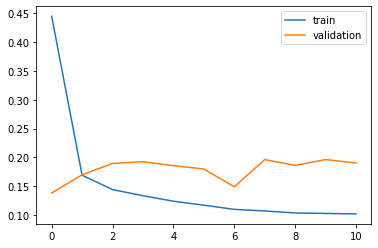


predict: [[30.6395389  23.33689959]]
real:      [[31.2 23.2]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4816 - mean_squared_error: 0.2852 - val_loss: 0.0886 - val_mean_squared_error: 0.0079
Epoch 2/1000
 - 0s - loss: 0.1933 - mean_squared_error: 0.0589 - val_loss: 0.2436 - val_mean_squared_error: 0.1029
Epoch 3/1000
 - 0s - loss: 0.1425 - mean_squared_error: 0.0317 - val_loss: 0.1260 - val_mean_squared_error: 0.0241
Epoch 4/1000
 - 0s - loss: 0.1333 - mean_squared_error: 0.0277 - val_loss: 0.1996 - val_mean_squared_error: 0.0595
Epoch 5/1000
 - 0s - loss: 0.1292 - mean_squared_error: 0.0262 - val_loss: 0.1611 - val_mean_squared_error: 0.0489
Epoch 6/1000
 - 0s - loss: 0.1234 - mean_squared_error: 0.0240 - val_loss: 0.1595 - val_mean_squared_error: 0.0438
Epoch 7/1000
 - 0s - loss: 0.1163 - mean_squared_error: 0.0217 - val_loss: 0.1350 - val_mean_squared_error: 0.0237
Epoch 8/1000
 - 0s - loss: 0.1142 - mean_squared_error: 0.0216 - val_loss: 0.1107 - va

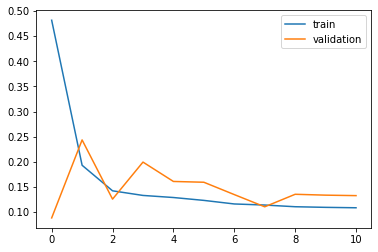


predict: [[27.14642704 21.62162881]]
real:      [[31.  21.1]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5206 - mean_squared_error: 0.3273 - val_loss: 0.4108 - val_mean_squared_error: 0.2181
Epoch 2/1000
 - 0s - loss: 0.2292 - mean_squared_error: 0.0891 - val_loss: 0.2447 - val_mean_squared_error: 0.0894
Epoch 3/1000
 - 0s - loss: 0.1482 - mean_squared_error: 0.0348 - val_loss: 0.1223 - val_mean_squared_error: 0.0291
Epoch 4/1000
 - 0s - loss: 0.1388 - mean_squared_error: 0.0296 - val_loss: 0.1351 - val_mean_squared_error: 0.0295
Epoch 5/1000
 - 0s - loss: 0.1352 - mean_squared_error: 0.0284 - val_loss: 0.1509 - val_mean_squared_error: 0.0320
Epoch 6/1000
 - 0s - loss: 0.1344 - mean_squared_error: 0.0279 - val_loss: 0.1292 - val_mean_squared_error: 0.0249
Epoch 7/1000
 - 0s - loss: 0.1319 - mean_squared_error: 0.0271 - val_loss: 0.1443 - val_mean_squared_error: 0.0311
Epoch 8/1000
 - 0s - loss: 0.1294 - mean_squared_error: 0.0263 - val_loss: 0.0881 - va

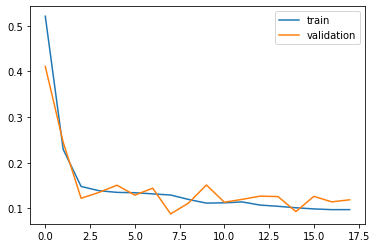


predict: [[31.65382146 23.00142531]]
real:      [[28.7 22.8]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3920 - mean_squared_error: 0.2021 - val_loss: 0.1012 - val_mean_squared_error: 0.0164
Epoch 2/1000
 - 0s - loss: 0.1667 - mean_squared_error: 0.0444 - val_loss: 0.0623 - val_mean_squared_error: 0.0043
Epoch 3/1000
 - 0s - loss: 0.1487 - mean_squared_error: 0.0340 - val_loss: 0.1533 - val_mean_squared_error: 0.0244
Epoch 4/1000
 - 0s - loss: 0.1392 - mean_squared_error: 0.0306 - val_loss: 0.1211 - val_mean_squared_error: 0.0147
Epoch 5/1000
 - 0s - loss: 0.1358 - mean_squared_error: 0.0288 - val_loss: 0.1530 - val_mean_squared_error: 0.0235
Epoch 6/1000
 - 0s - loss: 0.1328 - mean_squared_error: 0.0278 - val_loss: 0.1256 - val_mean_squared_error: 0.0158
Epoch 7/1000
 - 0s - loss: 0.1299 - mean_squared_error: 0.0267 - val_loss: 0.1232 - val_mean_squared_error: 0.0152
Epoch 8/1000
 - 0s - loss: 0.1249 - mean_squared_error: 0.0249 - val_loss: 0.1417 - va

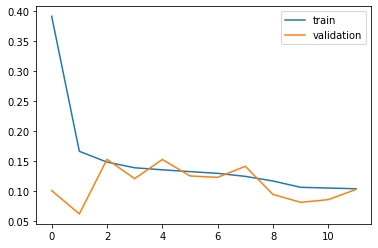


predict: [[30.61995314 22.2528465 ]]
real:      [[30.1 22.9]]



In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

min_max_scaler = preprocessing.MinMaxScaler()
values_scaled = min_max_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

plot_columns(values_scaled)

result = NCV(dataset_scaled, days_to_predict, min_max_scaler)

In [13]:
y_hats = result[0]
y_tests = result[1]

metrics(y_hats, y_tests)

Maximum metrics
Test RMSE -------------------------- 2.109
Test VARIANCE ---------------------- -1.244
Test MAX-ERROR --------------------- 6.274
Test MEAN-ABSOLUTE-ERROR ----------- 1.638
Test MEDIAN-ABSOLUTE-ERROR --------- 1.359

Accuracy
43.33% of predictions missed 1 point(s) or less
26.67% of predictions missed 2 point(s) or less
16.67% of predictions missed 3 point(s) or less
10.0% of predictions missed 4 point(s) or less

Minimum metrics
Test RMSE -------------------------- 0.7519
Test VARIANCE ---------------------- 0.05494
Test MAX-ERROR --------------------- 1.394
Test MEAN-ABSOLUTE-ERROR ----------- 0.6256
Test MEDIAN-ABSOLUTE-ERROR --------- 0.6755

Accuracy
80.0% of predictions missed 1 point(s) or less
20.0% of predictions missed 2 point(s) or less
